In [1]:
%pwd

'D:\\PyCharmProjects\\thesis'

In [1]:
from pyproj import Proj, transform
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import Geohash
import pynmea2
import math

In [2]:
path = r'teszt/szeged_trolli_teszt/nmea.log'

In [3]:
# Parse GSA sentence.
def _transform_gsa(parsed_sentence):
    hdop = float(parsed_sentence.hdop)
    gsa = {'hdop': hdop}
    return gsa

In [4]:
# Parse VTG sentence.
def _transform_vtg(parsed_sentence):
    v_ms = float(parsed_sentence.spd_over_grnd_kmph) / 3.6
    t = parsed_sentence.true_track

    vel_lng = float(v_ms) * math.cos(t)
    vel_lat = float(v_ms) * math.sin(t)

    vtg = {'t': t, 'v': v_ms, 'vlng': vel_lng, 'vlat': vel_lat}
    return vtg

In [5]:
# Parse GGA sentence.
def _transform_gga(parsed_sentence):
    ts = parsed_sentence.timestamp
    time = (ts.hour * 60 * 60 * 1000) + (ts.minute * 60 * 1000) + (ts.second * 1000) + ts.microsecond

    lng_deg = int(float(parsed_sentence.lon) / 100)
    lng = lng_deg + (float(parsed_sentence.lon) - lng_deg * 100) / 60
    if (parsed_sentence.lon_dir == 'W'):
        lng = lng * -1

    lat_deg = int(float(parsed_sentence.lat) / 100)
    lat = lat_deg + (float(parsed_sentence.lat) - lat_deg * 100) / 60
    if (parsed_sentence.lat_dir == 'S'):
        lat = lat * -1

    gga = {'time': time, 'lng': lng, 'lat': lat}
    return gga

In [6]:
# Helper function to tranform data to dictionary.
def _transform_data_to_dictionary(extracted_data):
    measurement_dictionary = {}

    gsa_list = extracted_data[0::3]
    vtg_list = extracted_data[1::3]
    gga_list = extracted_data[2::3]

    no_of_measurements = len(gga_list)

    if len(gsa_list) == len(vtg_list) == len(gga_list):
        for i in range(no_of_measurements):
            time_value = gga_list[i]['time']
            measurement_dictionary[time_value] = {**gsa_list[i], **vtg_list[i], **gga_list[i]}
    else:
        print("Something's not right")

    return measurement_dictionary

In [7]:
# Encode and then decode WGS84 coordinates to see where duplicates lie.
def _get_ghashed_eov_coordinates(lng, lat):
    ghashed = Geohash.encode(lng, lat, precision=10)
    lng_to_tf, lat_to_tf = Geohash.decode(ghashed)
    return {'lng': lng_to_tf, 'lat': lat_to_tf}

In [8]:
# Remove duplicate points and transform the projection to EOV.
def _remove_redundant_points(msrmnt_dict):
    in_proj = Proj(init='epsg:4326')
    out_proj = Proj(init='epsg:23700')
    time_list = sorted(list(msrmnt_dict.keys()))
    no_of_measurements = len(time_list)
    print('Original gps measurement count was: {}'.format(len(time_list)))
    list_of_dicts_of_gps_data = []
    counter = -1

    for i in range(no_of_measurements):
        m = msrmnt_dict[time_list[i]]
        ln, lt = m['lng'], m['lat']
        coords = _get_ghashed_eov_coordinates(ln, lt)
        lng, lat = transform(in_proj, out_proj, coords['lng'], coords['lat'])

        if not list_of_dicts_of_gps_data:
            list_of_dicts_of_gps_data.append({
                'time': m['time'], 'hdop': m['hdop'],
                'vlng': m['vlng'], 'vlat': m['vlat'],
                'lng': lng, 'lat': lat,
            })
            counter = counter + 1
        elif lng == list_of_dicts_of_gps_data[counter]['lng'] and lat == list_of_dicts_of_gps_data[counter]['lat']:
            pass
        else:
            list_of_dicts_of_gps_data.append({
                'time': m['time'], 'hdop': m['hdop'],
                'vlng': m['vlng'], 'vlat': m['vlat'],
                'lng': lng, 'lat': lat,
            })
            counter = counter + 1
    return list_of_dicts_of_gps_data

In [9]:
# Call parser functions and put returned data in a dictionary. Then remove redundant measurements from the dictionary.
def get_gps_dictionary(read_data):
    extracted_data = []

    dict_of_methods = {
        "<class 'pynmea2.types.talker.GSA'>": _transform_gsa,
        "<class 'pynmea2.types.talker.VTG'>": _transform_vtg,
        "<class 'pynmea2.types.talker.GGA'>": _transform_gga,
    }

    for row in read_data:
        if (('$GPGGA' in row) or ('$GPGSA' in row) or ('$GPVTG' in row)):
            parsed_sentence = pynmea2.parse(str(row))
            extracted_data.append(dict_of_methods[str(type(parsed_sentence))](parsed_sentence))

    msrmnt_dict = _transform_data_to_dictionary(extracted_data)
    measurement_dictionary = _remove_redundant_points(msrmnt_dict)
    return measurement_dictionary

In [10]:
with open(path, 'rt') as inputfile:
    read_data = inputfile.readlines()
    list_of_dicts_of_gps_data = get_gps_dictionary(read_data)
    gps_dataframe = pd.DataFrame(list_of_dicts_of_gps_data)
    print('Output gps measurement count was: {}'.format(len(list_of_dicts_of_gps_data)))

Original gps measurement count was: 209
Output gps measurement count was: 140


In [11]:
gps_dataframe

,hdop,lat,lng,time,vlat,vlng
0,2.0,102496.441071,735534.211646,59887000,0.885230,1.477301
1,2.0,102496.411744,735532.143832,59888000,1.337342,-1.294315
2,2.0,102496.353093,735528.008203,59889000,0.895115,-1.631718
3,2.0,102496.270986,735522.218323,59890000,-0.696719,-3.797731
4,2.0,102496.183021,735516.014880,59891000,4.319438,3.268445
5,2.0,102496.077471,735508.570748,59892000,3.330059,5.775392
6,2.0,102495.966067,735500.713053,59893000,7.018192,-0.366932
7,2.0,102495.842948,735492.028232,59894000,7.018192,-0.366932
8,2.0,102496.918224,735483.740071,59895000,7.156892,-0.374184
9,2.0,102496.806852,735475.882377,59896000,5.293684,-4.953727


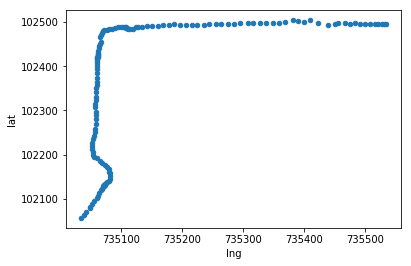

In [13]:
to_plot_df = gps_dataframe[['lng', 'lat']]
plt.show(to_plot_df.plot.scatter(x='lng', y='lat'))